In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

In [3]:
cd ~/Desktop

C:\Users\agilman\Desktop


# Completed function for Qp calculation

In [ ]:
df_compiled = pd.read_csv("compiled_data.txt", delimiter = "\t", encoding = 'unicode_escape')
df_compiled["Qp"] = np.nan #adding column to house data

for key, grp in df_compiled.groupby(["Sample ID"]):
    
    time_delta = grp["Runtime"].diff() #getting time delta (x axis delta)
    VCD_shift = grp["VCD"].shift() #shifting y column to do Yn + Y(n-1) for every row
    VCD_trapezoids = (grp["VCD"] + VCD_shift)*time_delta/2 #area of each trapezoid 
    IVCD = VCD_trapezoids.cumsum()*(10**6) #integrated area in units cells/mL * days
    titer_pg_ml = grp["Titer"]*(10**9) #converting titer to pg/ml
    qp = titer_pg_ml/IVCD

    ind = qp.index #getting the index
    
    df_compiled.loc[ind,"Qp"] = qp

# Completed Runtime calculated for ViCell combined BSR files
For BSR file coming off ViCell that contains data from multiple reactors 

In [ ]:
df = pd.read_csv("BSR5.txt", delimiter = "\t", encoding = 'unicode_escape')

In [37]:
### Changing the dataframe to more useful format ####
df.drop_duplicates(subset = "Sample date/time", inplace = True) #dropping duplicate rows
df["Sample date/time"]= pd.to_datetime(df["Sample date/time"]) #converting to datetime format 
df["Sample ID"] = df["Sample ID"].str.slice(0,5) #shortening Sample ID colum to first 4 characters 
df["File name"] = df["File name"].str.slice(0,5) #shortening "File name" column
df.sort_values(by ="Sample date/time", inplace = True) #sorting chronologically 
df["Runtime"] = 0 #empty column with zeros 


for key, grp in df.groupby(["File name"]):
    
    time_delta = grp["Sample date/time"].diff() #time difference 
    time_delta = time_delta.dt.total_seconds() / (24 * 60 * 60) #converting to float
    added_time = time_delta.cumsum() #added time 
    added_time.iloc[0] = 0 #setting the first value to zero instead of Nan 

    ind = added_time.index

    df.loc[ind,"Runtime"] = added_time


### Making Qp plots

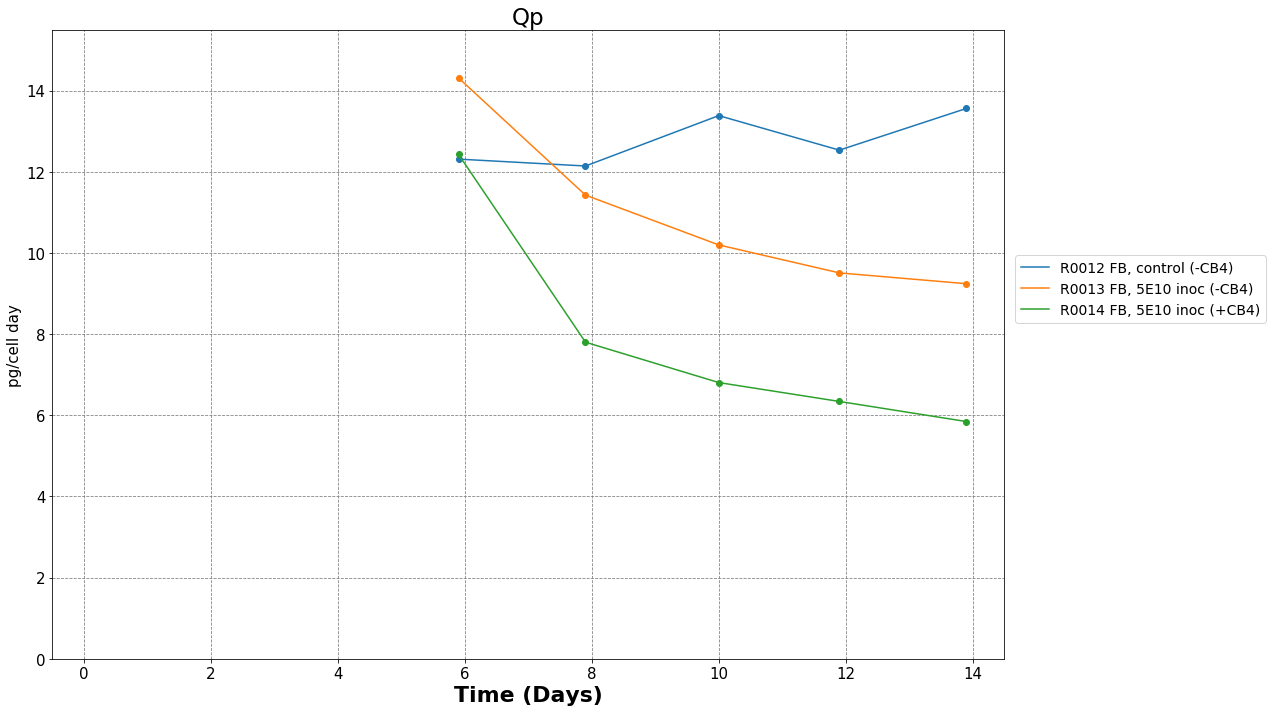

In [63]:
data = df_compiled.copy()

list_BSR3 = ["R0007","R0008","R0009","R0010"]
list_BSR4 = [ "R0012","R0013","R0014"]
data = data[data["Sample ID"].isin(list_BSR4)]

dict_label = {"R0007":"Perfusion",
              "R0008":"Perfusion",
              "R0009":"Fed-Batch",
              "R0010":"Fed-Batch",
              "R0011":"Perfusion, 0.2um",
              "R0012":"FB, control (-CB4)",
              "R0013": "FB, 5E10 inoc (-CB4)",
              "R0014": "FB, 5E10 inoc (+CB4)"}

xmin = -0.5
xmax = 14.5

dict_ymin = {'VCD':0, 'Viability':40, 'Titer':0, 'O2 Saturation':0, 'PCO2':0, 
            'Gluc':0, 'Lac':0,'pH':6.4,'NH4+':0,'Gln':0, 'Glu':0,'Na+':0, 'K+':0, 'Ca++':0,
            "Qp":0}


list1_1itms = ["Qp"]
dict1_1itms = {"Qp":"pg/cell day"}



#################################################################################


fig = plt.figure(figsize = (20,10))

ax = fig.add_subplot(1,1,1)

i = "Qp"
value = "pg/cell day"

#iterating over grouped reactor ID
for key, grp in data.groupby(['Sample ID']): 
    ax.scatter(grp['Runtime'], grp[i], label='_nolegend_') #Point plots
    mask = np.isfinite(grp[i])
    ax.plot(grp['Runtime'][mask], grp[i][mask], label=(key + " " + dict_label[key])) #line plots
        
        
ax.set_xlim(left = xmin, right = xmax) #forcing a zero lower x limit (titer)
ax.tick_params(axis='both', which='major', labelsize=15) #tick labels size 
ax.set_ylabel(value , fontsize = 15) #y-axis label


ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

ax.set_title(i, fontsize = 23)

ymin, ymax = ax.get_ylim() #get the min and max of respective axes
ax.set_ylim(bottom = dict_ymin[i], top = ymax*1.05 ) #bottom defined by dict per each param, top = max*1.05

#adding x-axis on the last subplot

ax.set_xlabel("Time (Days)", fontsize = 22, fontweight = "bold") #x-axis label


handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels,  bbox_to_anchor = (0.7,.644), loc = "upper left", fontsize = 14 )
fig.tight_layout()
fig.subplots_adjust(right=0.7) 


plt.savefig("Figure_Qp.png", dpi = 500)
